In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10, cifar100
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
import numpy as np
import random
import matplotlib.pyplot as plt



'\n\n# Generating Perturbations\n\n\n\n# Defending Against Adversarial Attacks\n\n\n'

In [ ]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [ ]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu',
                     input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

In [ ]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))


print("Base accuracy  regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0063 - accuracy: 0.9595 - val_loss: 0.0040 - val_accuracy: 0.9733
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0056 - accuracy: 0.9642 - val_loss: 0.0037 - val_accuracy: 0.9747
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0052 - accuracy: 0.9671 - val_loss: 0.0034 - val_accuracy: 0.9779
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0048 - accuracy: 0.9692 - val_loss: 0.0036 - val_accuracy: 0.9778
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0046 - accuracy: 0.9703 - val_loss: 0.0033 - val_accuracy: 0.9800
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0043 - accuracy: 0.9730 - val_loss: 0.0033 - val_accuracy: 0.9799
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0042 - accuracy: 0.9737 - val_loss: 0.0034 - val_accuracy

In [ ]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad


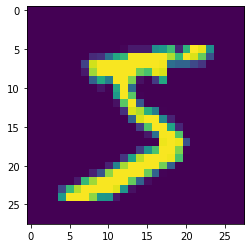

Original Image Prediction:  five
Adversarial Image Prediction:  three


In [ ]:
image = x_train[0]
image_label = y_train[0]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()

adversarial = image + perturbations * 0.1
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
    plt.imshow(image.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
    plt.imshow(image.reshape((img_rows, img_cols, channels)))
plt.show()
print("Original Image Prediction: ", labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print("Adversarial Image Prediction: ", labels[model.predict(adversarial).argmax()])


In [ ]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]

            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()

            epsilon = 0.05
            adversarial = image + perturbations * epsilon

            x.append(adversarial)
            y.append(y_train[N])

        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)

        yield x, y


x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Base accuracy adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy adversarial images: [0.05965438857674599, 0.6449999809265137]


In [ ]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0028 - accuracy: 0.9847 - val_loss: 0.0059 - val_accuracy: 0.9654
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 1.1496e-04 - accuracy: 0.9993 - val_loss: 0.0063 - val_accuracy: 0.9635
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 1.0834e-04 - accuracy: 0.9992 - val_loss: 0.0063 - val_accuracy: 0.9634
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 8.3408e-05 - accuracy: 0.9995 - val_loss: 0.0068 - val_accuracy: 0.9605
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 1.1894e-04 - accuracy: 0.9992 - val_loss: 0.0069 - val_accuracy: 0.9601
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 8.4064e-05 - accuracy: 0.9995 - val_loss: 0.0061 - val_accuracy: 0.9645
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 1.0178e-04 - accuracy: 0.9994 - val_loss: 0.0094 - val

In [ ]:
print("Defended accuracy adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))
print("Defended accuracy regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy adversarial images: [4.6726613894314106e-18, 1.0]
Defended accuracy regular images: [0.008506928570568562, 0.9524000287055969]
